## Earthquake AI - Modelling

## 1. Initial Model

Loading and splitting data …
Data ready.

Model: LGBMClassifier
Train accuracy:0.5692
Confusion matrix:
[[ 5241  4927     9     0     0]
 [ 3057 29273  2605   192   281]
 [  713 13433  3883   280   674]
 [   29  2099   676   244    94]
 [    0   148    58    29    84]]
Train average ROC AUC: 0.7657


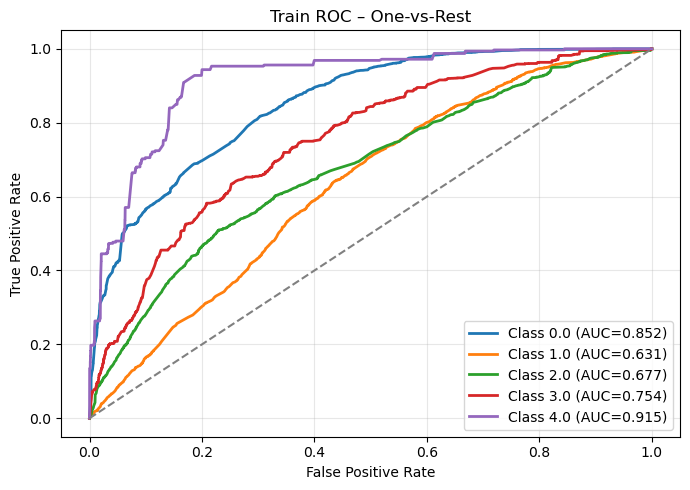

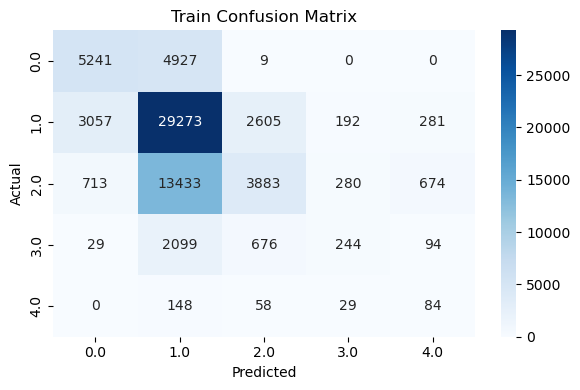


Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.51      0.55     10177
         1.0       0.59      0.83      0.69     35408
         2.0       0.54      0.20      0.30     18983
         3.0       0.33      0.08      0.13      3142
         4.0       0.07      0.26      0.12       319

    accuracy                           0.57     68029
   macro avg       0.42      0.38      0.35     68029
weighted avg       0.56      0.57      0.53     68029

Test accuracy:0.5214
Confusion matrix:
[[1181  971    7    0   16]
 [ 693 6169  769   94  184]
 [ 145 3222  780   33  141]
 [  37  905   95    0   34]
 [   0  116    0    0    0]]
Test average ROC AUC: 0.6239


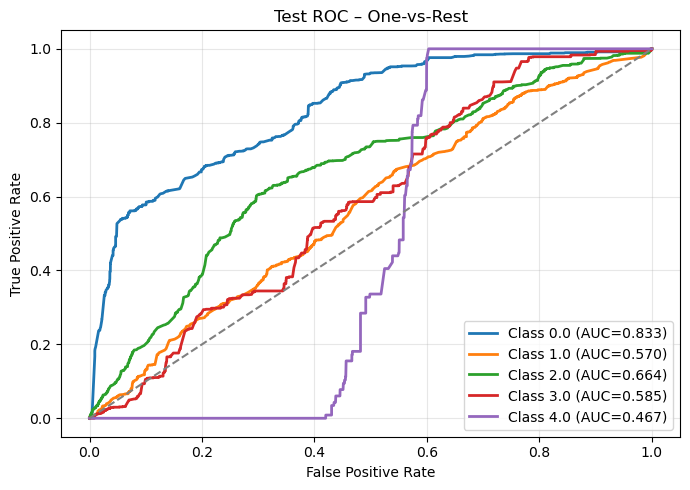

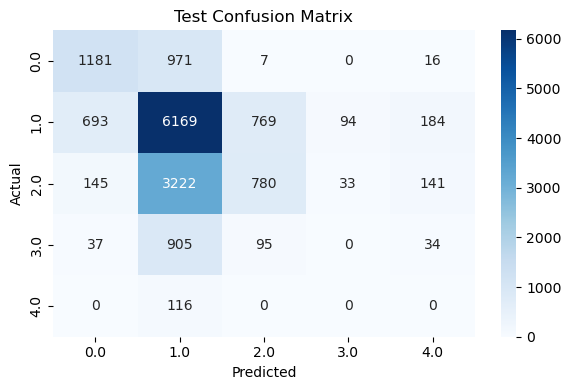


Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.54      0.56      2175
         1.0       0.54      0.78      0.64      7909
         2.0       0.47      0.18      0.26      4321
         3.0       0.00      0.00      0.00      1071
         4.0       0.00      0.00      0.00       116

    accuracy                           0.52     15592
   macro avg       0.32      0.30      0.29     15592
weighted avg       0.49      0.52      0.47     15592

SHAP exposition …


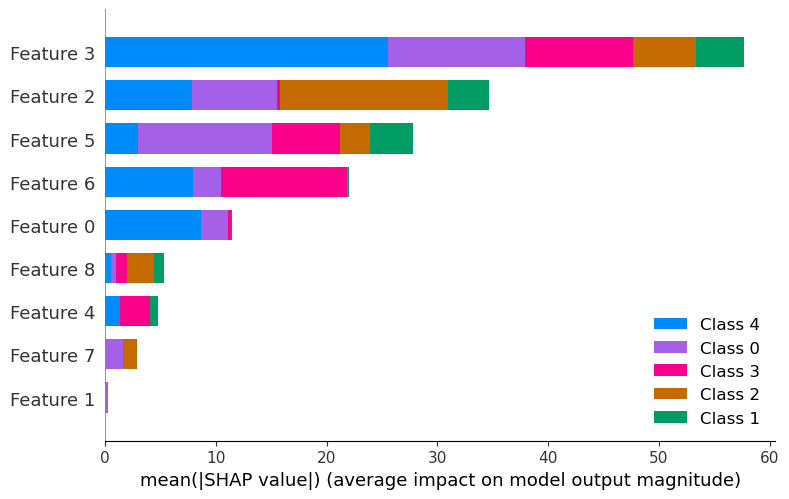

In [1]:
# ----------------------------------------------------------
# 0. Imports
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import shap                                      # Explainability

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report, roc_curve, auc)

# ------------------ Model Imports ------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# ----------------------------------------------------------
# 1. Data utilities
# ----------------------------------------------------------
def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train–test split.
    Returns X_train, X_test, y_train, y_test.
    """
    print("Loading and splitting data …")
    df = pd.read_parquet(path).drop(columns=["magnitudes_list"])
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)

    target = "max_mag_next_30d" if task == "regression" else "target_class"
    df = df.dropna(subset=[target])
    X, y = df.drop(columns=["max_mag_next_30d", "target_class"]), df[target]

    if task == "classification":
        y = y - 1            # shift labels to start at 0
        # y = y >= 3           # bool → two classes (False / True)

    # # ---- project-specific: collapse to binary “≥3” vs “<3” -------------
    # if task == "classification":
    #     y = y >= 3           # bool → two classes (False / True)

    # ---- temporal split -----------------------------------------------
    X_train = X.loc[X.date <  "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date <  "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()

    # keep only labels appearing in both splits
    common = set(y_train.unique()) & set(y_test.unique())
    mask_tr = y_train.isin(common)
    mask_te = y_test.isin(common)
    X_train, y_train = X_train.loc[mask_tr].drop(columns=["date"]), y_train[mask_tr]
    X_test,  y_test  = X_test.loc[mask_te].drop(columns=["date"]),  y_test[mask_te]

    print("Data ready.")
    return X_train, X_test, y_train, y_test


def build_preprocessor():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler())
    ])


# ----------------------------------------------------------
# 2. Model factory  (unchanged)
# ----------------------------------------------------------
def get_model_and_param_grid(model_name: str, task: str, y_train=None):
    # ------------- add / adjust models as needed -------------
    if task == "regression":
        if model_name == "XGBRegressor":
            model = XGBRegressor(
                n_estimators=1_000, learning_rate=0.01, max_depth=3,
                min_child_weight=10, gamma=0.5, subsample=0.7,
                colsample_bytree=0.7, reg_lambda=10, reg_alpha=1,
                random_state=42
            )
            param_grid = {"model__max_depth":[3,5],
                          "model__learning_rate":[0.01,0.05],
                          "model__min_child_weight":[10,20]}
        else:
            model, param_grid = LinearRegression(), {}
    else:  # classification
        if model_name == "LGBMClassifier":
            model = LGBMClassifier(
                num_leaves=10, max_depth=2, min_child_samples=50,
                colsample_bytree=0.7, subsample=0.7,
                learning_rate=0.01, n_estimators=50, boosting_type="rf",
                reg_alpha=0.8, reg_lambda=0.8, cat_smooth=10,
                is_unbalance=True, random_state=42, verbose=-1
            )
            param_grid = {"model__num_leaves":[15,31,50],
                          "model__learning_rate":[0.005,0.01,0.05]}
        else:
            model, param_grid = LogisticRegression(max_iter=1_000), {"model__C":[0.1,1,10]}
    return model, param_grid


# ----------------------------------------------------------
# 3-a. Post-hoc threshold logic
# ----------------------------------------------------------
def predict_with_thresholds(pipe, X, thresholds=None, default_rule="argmax"):
    """
    Force a prediction to class k whenever proba[k] ≥ τ_k.
    """
    if not thresholds:
        return pipe.predict(X)

    proba   = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_
    idx_map = {c:i for i,c in enumerate(classes)}

    preds = np.argmax(proba, axis=1) if default_rule=="argmax" \
            else np.full(len(X), -1)

    for cls, τ in thresholds.items():
        if cls not in idx_map: continue
        preds[proba[:, idx_map[cls]] >= τ] = cls
    return preds


# ----------------------------------------------------------
# 3-b.  Plotting & evaluation  (ROC now handles 2 or >2 classes)
# ----------------------------------------------------------
def plot_roc_auc(pipe, X, y, dataset):
    """
    Draw a single ROC curve for binary problems, or
    One-vs-Rest curves for multi-class.
    """
    if not hasattr(pipe.named_steps["model"], "predict_proba"):
        print("Model lacks predict_proba – skipping ROC curves.")
        return

    y_score = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_

    plt.figure(figsize=(7, 5))
    if len(classes) == 2:
        pos_proba = y_score[:, 1]          # column 1 → positive class
        fpr, tpr, _ = roc_curve(y, pos_proba)
        plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC curve (binary)")
    else:
        y_bin = label_binarize(y, classes=classes)
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC – One-vs-Rest")

    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


def evaluate_regression(pipe, X, y, dataset):
    y_pred = pipe.predict(X)
    print(f"{dataset} → MSE:{mean_squared_error(y,y_pred):.4f} | "
          f"MAE:{mean_absolute_error(y,y_pred):.4f} | "
          f"R²:{r2_score(y,y_pred):.4f}")


def evaluate_classification(pipe, X, y, dataset, thresholds=None):
    y_pred  = predict_with_thresholds(pipe, X, thresholds)
    acc     = accuracy_score(y, y_pred)
    cm      = confusion_matrix(y, y_pred)
    print(f"{dataset} accuracy:{acc:.4f}\nConfusion matrix:\n{cm}")

    # Compute and print average ROC AUC
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_score = pipe.predict_proba(X)
        classes = pipe.named_steps["model"].classes_
        y_bin = label_binarize(y, classes=classes)
        aucs = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            aucs.append(auc(fpr, tpr))
        avg_auc = np.mean(aucs)
        print(f"{dataset} average ROC AUC: {avg_auc:.4f}")
    else:
        print(f"{dataset} → model lacks predict_proba; skipping AUC.")

    plot_roc_auc(pipe, X, y, dataset)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{dataset} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

    print("\nClassification Report:")
    print(classification_report(y, y_pred))



def plot_shap_values(pipe, X, model_name):
    tree = pipe.named_steps["model"]
    X_trans = pipe.named_steps["preprocessor"].transform(X)
    explainer = shap.TreeExplainer(tree)
    shap.summary_plot(explainer.shap_values(X_trans),
                      X_trans, plot_type="bar", max_display=10, show=True)


# ----------------------------------------------------------
# 4. Run-level parameters
# ----------------------------------------------------------
task        = "classification"     # "regression" or "classification"
do_tuning   = False
models_to_run = ["LGBMClassifier"] if task=="classification" else ["XGBRegressor"]

# ---- Optional post-hoc probability thresholds --------
apply_thresholds = False
class_thresholds = {2: 0.30, 3: 0.25}       # example for multi-class use-case


# ----------------------------------------------------------
# 5. Pipeline run
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = load_and_split_data(
    "./earthquake_prediction/data/features/earthquake_features.parquet", task
)

# drop sparse / list columns
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) \
          + [c for c in X_train.columns if "list" in c]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# keep top-10 features
top_10 = [
    "time_since_class_4","time_since_class_3","rolling_T_value",
    "daily_count_30d_sum","daily_b_value","rolling_dE_half",
    "daily_etas_intensity","time_since_class_2","daily_count_7d_sum"
]
X_train, X_test = X_train[top_10], X_test[top_10]

preprocessor = build_preprocessor()
cv_split     = TimeSeriesSplit(n_splits=3)

for mdl in models_to_run:
    print("\n"+"="*75)
    print(f"Model: {mdl}")

    model, param_grid = get_model_and_param_grid(mdl, task, y_train)
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])

    if do_tuning and param_grid:
        search = RandomizedSearchCV(
            pipe, param_distributions=param_grid, cv=cv_split,
            scoring="accuracy" if task=="classification" else "r2",
            n_iter=50, random_state=42, n_jobs=-1, verbose=2
        ).fit(X_train, y_train)
        pipe = search.best_estimator_
        print("Best params:", search.best_params_)
    else:
        pipe.fit(X_train, y_train)

    thresh = class_thresholds if (apply_thresholds and task=="classification") else None

    if task == "regression":
        evaluate_regression(pipe, X_train, y_train, "Train")
        evaluate_regression(pipe, X_test,  y_test,  "Test")
    else:
        evaluate_classification(pipe, X_train, y_train, "Train", thresholds=thresh)
        evaluate_classification(pipe, X_test,  y_test,  "Test",  thresholds=thresh)

    print("SHAP exposition …")
    plot_shap_values(pipe, X_train, mdl)
    print("="*75+"\n")


## 2. Embeddings + Tabular features

In [2]:
!ls

earthquake_prediction


Data ready. Train rows: 418, Test rows: 200
--Return--
None
> /tmp/ipykernel_1012714/1466038325.py(302)<module>()
    301 
--> 302 import ipdb; ipdb.set_trace()
    303 X_train.drop(columns=drop_cols, inplace=True)


Model: LGBMClassifier
None
> /tmp/ipykernel_1012714/1466038325.py(342)<module>()
    341         import ipdb; ipdb.set_trace()
--> 342         pipe.fit(X_train, y_train)
    343 

Train accuracy:0.6411
Confusion matrix:
[[ 49  24   0   0]
 [  9 219   0   0]
 [  9  79   0   0]
 [  0  29   0   0]]
Train average ROC AUC: 0.8362


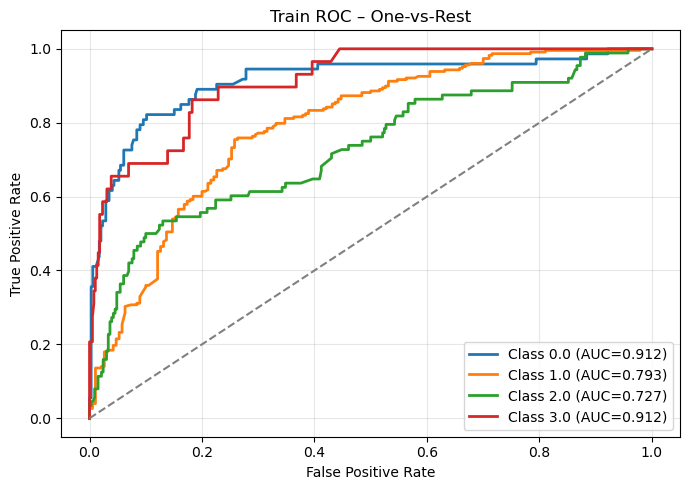

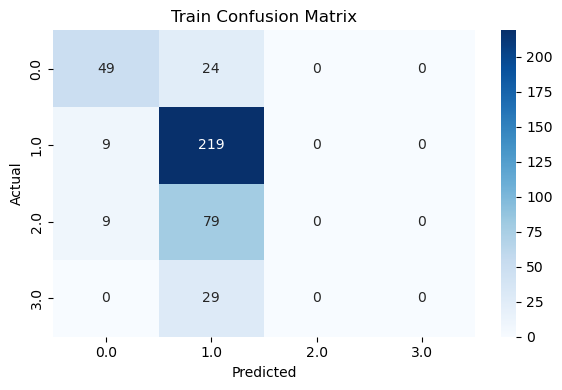


Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.67      0.70        73
         1.0       0.62      0.96      0.76       228
         2.0       0.00      0.00      0.00        88
         3.0       0.00      0.00      0.00        29

    accuracy                           0.64       418
   macro avg       0.34      0.41      0.36       418
weighted avg       0.47      0.64      0.53       418

Test accuracy:0.4050
Confusion matrix:
[[46  8  0  0]
 [52 35  1  0]
 [11 30  0  0]
 [ 6 11  0  0]]
Test average ROC AUC: 0.6002


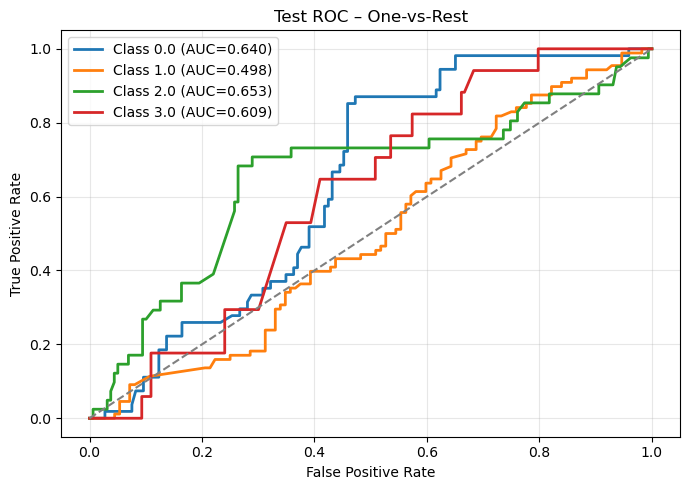

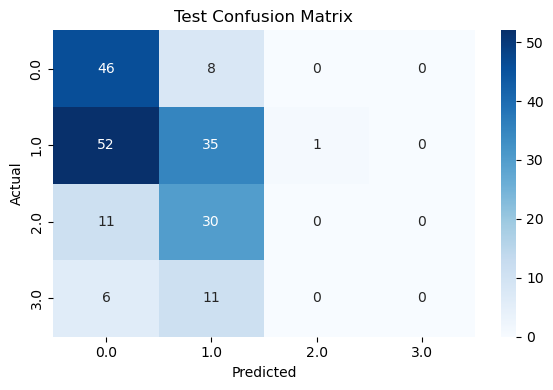


Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.85      0.54        54
         1.0       0.42      0.40      0.41        88
         2.0       0.00      0.00      0.00        41
         3.0       0.00      0.00      0.00        17

    accuracy                           0.41       200
   macro avg       0.20      0.31      0.24       200
weighted avg       0.29      0.41      0.33       200

SHAP exposition …


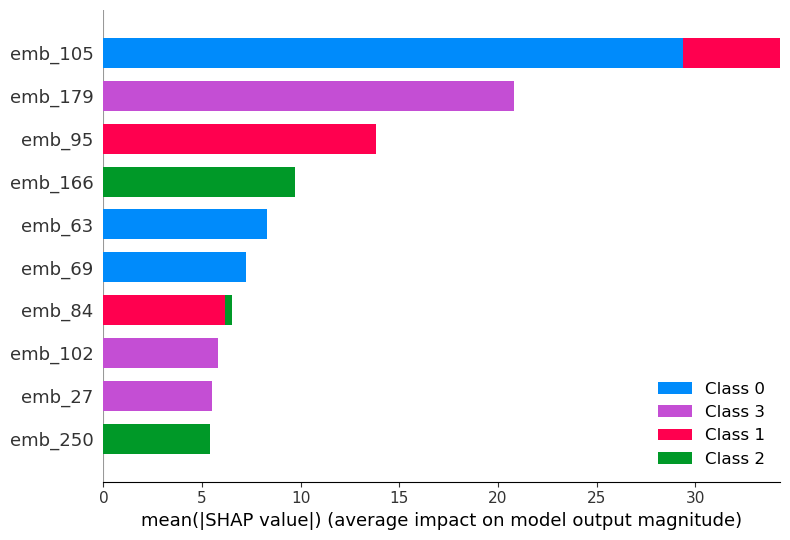

In [10]:
# ----------------------------------------------------------
# 0. Imports
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import shap                                      # Explainability

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report, roc_curve, auc)

# ------------------ Model Imports ------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# ----------------------------------------------------------
# 1. Data utilities
# ----------------------------------------------------------
# ----------------------------------------------------------
# 1. Data utilities  ➜  now merges seismic embeddings
# ----------------------------------------------------------
def load_and_split_data(daily_path: str,
                        seismic_path: str,
                        task: str):
    """
    1.  Read the daily-feature table  (df_daily)  and the seismic-window table
        with embeddings  (df_seismic).
    2.  Expand the `embedding` list into emb_0 … emb_(d–1) columns.
    3.  Merge on  (station_code / station)  and  (date == period_end  w/o tz).
    4.  Temporal train / test split.
    """
    # --------------------  read tables  --------------------
    df_daily   = pd.read_parquet(daily_path)
    df_seismic = pd.read_pickle("./earthquake_prediction/data//features/embeddings_190102.pkl") # CHANGE THIS PATH

    # ------------------  explode embeddings  ---------------
    emb_dim   = len(df_seismic.iloc[0, df_seismic.columns.get_loc("embedding")])
    emb_cols  = [f"emb_{i}" for i in range(emb_dim)]
    df_emb    = pd.DataFrame(df_seismic["embedding"].tolist(), columns=emb_cols)

    df_seismic_exp = pd.concat(
        [df_seismic.drop(columns=["embedding"]), df_emb],
        axis=1
    )

    # ------------------  align time keys  ------------------
    df_seismic_exp["period_end"] = (
        pd.to_datetime(df_seismic_exp["period_end"]).dt.tz_convert(None)
    )
    df_seismic_exp["period_end"] = pd.to_datetime(df_seismic_exp["period_end"].dt.date)
    df_daily["date"] = pd.to_datetime(df_daily["date"])

    # ------------------  merge (inner)  --------------------
    df = pd.merge(
        df_daily,                                          # left
        df_seismic_exp.drop(columns=["period_start", "label"]),
        left_on=["date",        "station_code"],
        right_on=["period_end", "station"],
        how="inner",
    ).drop(columns=["period_end", "station"])


    # ------------------  target & feature split ------------
    if task == "regression":
        target = "max_mag_next_30d"
    else:
        target = "target_class"

    
    df = df.dropna(subset=[target]).copy()
    df["date"] = pd.to_datetime(df["date"])      # make sure

    X  = df.drop(columns=["max_mag_next_30d", "target_class"])
    y  = df[target]
    if task == "classification":
        y = y - 1                     # labels start at 0
        # y = y >= 3



    # ---------------  temporal train / test  ---------------
    X_train = X.loc[X.date <  "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-01"].copy()
    y_train = y.loc[X.date <  "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-01"].copy()

    # keep only labels seen in both splits
    common  = set(y_train.unique()) & set(y_test.unique())
    mask_tr = y_train.isin(common)
    mask_te = y_test.isin(common)

    X_train, y_train = X_train.loc[mask_tr].drop(columns=["date"]), y_train[mask_tr]
    X_test,  y_test  = X_test.loc[mask_te].drop(columns=["date"]),  y_test[mask_te]

    print(f"Data ready. Train rows: {len(X_train)}, Test rows: {len(X_test)}")
    return X_train, X_test, y_train, y_test

#import PCA from sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
import umap

def build_preprocessor():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler()),
        # ("pca",     PCA(n_components=0.8)),
        # ("isomap",    Isomap(n_components=10, n_neighbors=15))
        # ("umap",    umap.UMAP(n_components=10))
        # ("ica", FastICA(n_components=10, random_state=0))
    ])


# ----------------------------------------------------------
# 2. Model factory  (unchanged)
# ----------------------------------------------------------
def get_model_and_param_grid(model_name: str, task: str, y_train=None):
    # ------------- add / adjust models as needed -------------
    if task == "regression":
        if model_name == "XGBRegressor":
            model = XGBRegressor(
                n_estimators=1_000, learning_rate=0.01, max_depth=3,
                min_child_weight=10, gamma=0.5, subsample=0.7,
                colsample_bytree=0.7, reg_lambda=10, reg_alpha=1,
                random_state=42
            )
            param_grid = {"model__max_depth":[3,5],
                          "model__learning_rate":[0.01,0.05],
                          "model__min_child_weight":[10,20]}
        else:
            model, param_grid = LinearRegression(), {}
    else:  # classification
        if model_name == "LGBMClassifier":
            model = LGBMClassifier(
                num_leaves=10, max_depth=2, min_child_samples=50,
                colsample_bytree=0.7, subsample=0.7,
                learning_rate=0.01, n_estimators=50, boosting_type="rf",
                reg_alpha=0.8, reg_lambda=0.8, cat_smooth=10,
                is_unbalance=True, random_state=42, verbose=-1
            )
            param_grid = {"model__num_leaves":[15,31,50],
                          "model__learning_rate":[0.005,0.01,0.05]}
        else:
            model, param_grid = LogisticRegression(max_iter=1_000), {"model__C":[0.1,1,10]}
    return model, param_grid


# ----------------------------------------------------------
# 3-a. Post-hoc threshold logic
# ----------------------------------------------------------
def predict_with_thresholds(pipe, X, thresholds=None, default_rule="argmax"):
    """
    Force a prediction to class k whenever proba[k] ≥ τ_k.
    """
    if not thresholds:
        return pipe.predict(X)

    proba   = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_
    idx_map = {c:i for i,c in enumerate(classes)}

    preds = np.argmax(proba, axis=1) if default_rule=="argmax" \
            else np.full(len(X), -1)

    for cls, τ in thresholds.items():
        if cls not in idx_map: continue
        preds[proba[:, idx_map[cls]] >= τ] = cls
    return preds


# ----------------------------------------------------------
# 3-b.  Plotting & evaluation  (ROC now handles 2 or >2 classes)
# ----------------------------------------------------------
def plot_roc_auc(pipe, X, y, dataset):
    """
    Draw a single ROC curve for binary problems, or
    One-vs-Rest curves for multi-class.
    """
    if not hasattr(pipe.named_steps["model"], "predict_proba"):
        print("Model lacks predict_proba – skipping ROC curves.")
        return

    y_score = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_

    plt.figure(figsize=(7, 5))
    if len(classes) == 2:
        pos_proba = y_score[:, 1]          # column 1 → positive class
        fpr, tpr, _ = roc_curve(y, pos_proba)
        plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC curve (binary)")
    else:
        y_bin = label_binarize(y, classes=classes)
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC – One-vs-Rest")

    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


def evaluate_regression(pipe, X, y, dataset):
    y_pred = pipe.predict(X)
    print(f"{dataset} → MSE:{mean_squared_error(y,y_pred):.4f} | "
          f"MAE:{mean_absolute_error(y,y_pred):.4f} | "
          f"R²:{r2_score(y,y_pred):.4f}")


def evaluate_classification(pipe, X, y, dataset, thresholds=None):
    y_pred  = predict_with_thresholds(pipe, X, thresholds)
    acc     = accuracy_score(y, y_pred)
    cm      = confusion_matrix(y, y_pred)
    print(f"{dataset} accuracy:{acc:.4f}\nConfusion matrix:\n{cm}")

    # Compute and print average ROC AUC
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_score = pipe.predict_proba(X)
        classes = pipe.named_steps["model"].classes_
        y_bin = label_binarize(y, classes=classes)
        aucs = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            aucs.append(auc(fpr, tpr))
        avg_auc = np.mean(aucs)
        print(f"{dataset} average ROC AUC: {avg_auc:.4f}")
    else:
        print(f"{dataset} → model lacks predict_proba; skipping AUC.")

    plot_roc_auc(pipe, X, y, dataset)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{dataset} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

    print("\nClassification Report:")
    print(classification_report(y, y_pred))



def plot_shap_values(pipe, X, model_name):
    tree      = pipe.named_steps["model"]
    X_trans   = pipe.named_steps["preprocessor"].transform(X)
    explainer = shap.TreeExplainer(tree)
    shap_vals = explainer.shap_values(X_trans)

    shap.summary_plot(
        shap_vals,
        X_trans,
        feature_names=list(X.columns),
        plot_type="bar",
        max_display=10,
        show=True
    )

# ----------------------------------------------------------
# 4. Run-level parameters
# ----------------------------------------------------------
task        = "classification"     # "regression" or "classification"
do_tuning   = False
models_to_run = ["LGBMClassifier"] if task=="classification" else ["XGBRegressor"]

# ---- Optional post-hoc probability thresholds --------
apply_thresholds = False
class_thresholds = {2: 0.30, 3: 0.25}       # example for multi-class use-case


# ----------------------------------------------------------
# 5. Pipeline run
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = load_and_split_data(
    daily_path   = "./earthquake_prediction/data/features/earthquake_features.parquet",
    seismic_path = "./earthquake_prediction/data/features/df_seismic.parquet",   # << path to your seismic file
    task = task
)


# drop sparse / list columns
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) \
          + [c for c in X_train.columns if "list" in c]

import ipdb; ipdb.set_trace()
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# keep top-10 features
# keep top engineered features + ALL embedding columns
emb_cols  = [c for c in X_train.columns if c.startswith("emb_")]
top_feats = [
    # "time_since_class_4",
    "time_since_class_3",
    "rolling_T_value",
             "daily_count_30d_sum","daily_b_value","rolling_dE_half",
             "daily_etas_intensity","time_since_class_2","daily_count_7d_sum"]

# X_train = X_train[top_feats + emb_cols]
# X_test  = X_test [top_feats + emb_cols]

X_train = X_train[emb_cols]
X_test  = X_test [emb_cols]

preprocessor = build_preprocessor()
cv_split     = TimeSeriesSplit(n_splits=3)

for mdl in models_to_run:
    print("\n"+"="*75)
    print(f"Model: {mdl}")

    model, param_grid = get_model_and_param_grid(mdl, task, y_train)
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])

    if do_tuning and param_grid:
        search = RandomizedSearchCV(
            pipe, param_distributions=param_grid, cv=cv_split,
            scoring="accuracy" if task=="classification" else "r2",
            n_iter=50, random_state=42, n_jobs=-1, verbose=2
        ).fit(X_train, y_train)
        pipe = search.best_estimator_
        print("Best params:", search.best_params_)
    else:
        import ipdb; ipdb.set_trace()
        pipe.fit(X_train, y_train)

    thresh = class_thresholds if (apply_thresholds and task=="classification") else None

    if task == "regression":
        evaluate_regression(pipe, X_train, y_train, "Train")
        evaluate_regression(pipe, X_test,  y_test,  "Test")
    else:
        evaluate_classification(pipe, X_train, y_train, "Train", thresholds=thresh)
        evaluate_classification(pipe, X_test,  y_test,  "Test",  thresholds=thresh)

    print("SHAP exposition …")
    plot_shap_values(pipe, X_train, mdl)
    print("="*75+"\n")

2025-05-26 12:49:27.393596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-26 12:49:27.410055: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-26 12:49:27.414982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-26 12:49:27.427244: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Data ready. Train rows: 418, Test rows: 200

Model: LGBMClassifier
Train accuracy:0.7129
Confusion matrix:
[[ 57  15   1   0]
 [  6 187  22  13]
 [  6  44  34   4]
 [  0   9   0  20]]
Train average ROC AUC: 0.8874


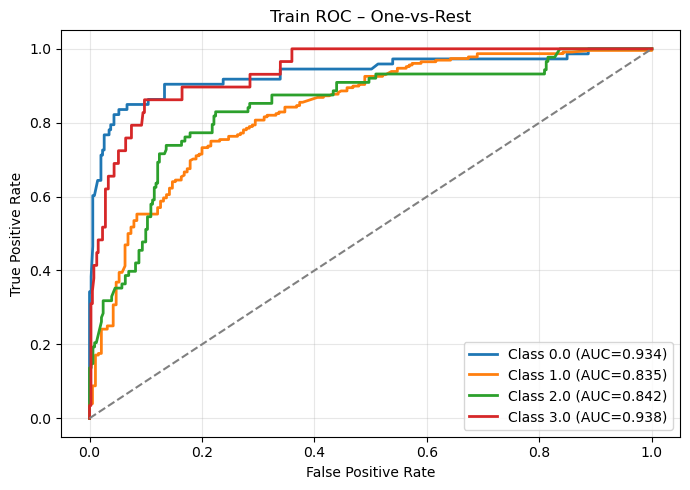

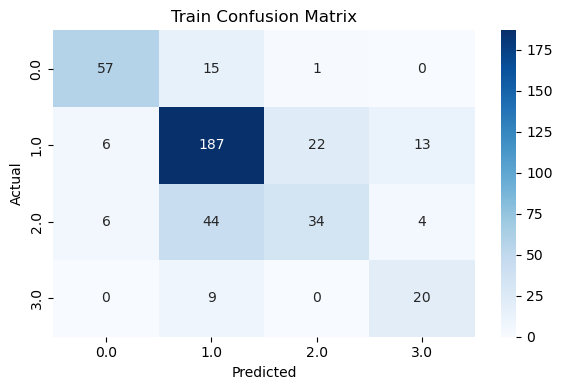


Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      0.78      0.80        73
         1.0       0.73      0.82      0.77       228
         2.0       0.60      0.39      0.47        88
         3.0       0.54      0.69      0.61        29

    accuracy                           0.71       418
   macro avg       0.67      0.67      0.66       418
weighted avg       0.71      0.71      0.70       418

Test accuracy:0.5200
Confusion matrix:
[[40 13  0  1]
 [21 57  0 10]
 [ 0 29  6  6]
 [ 0 16  0  1]]
Test average ROC AUC: 0.7415


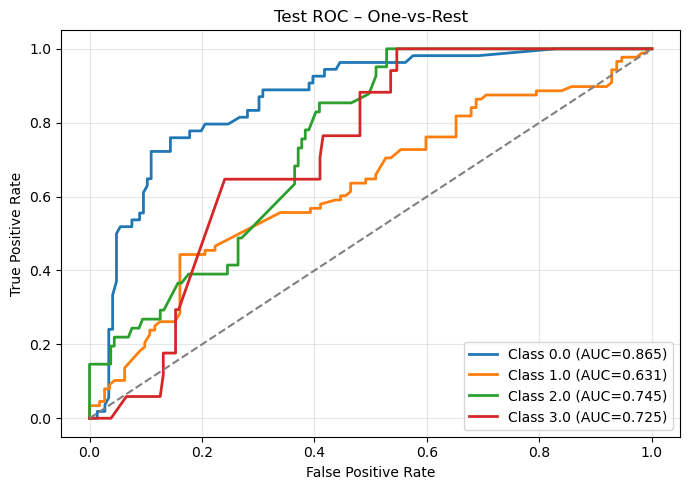

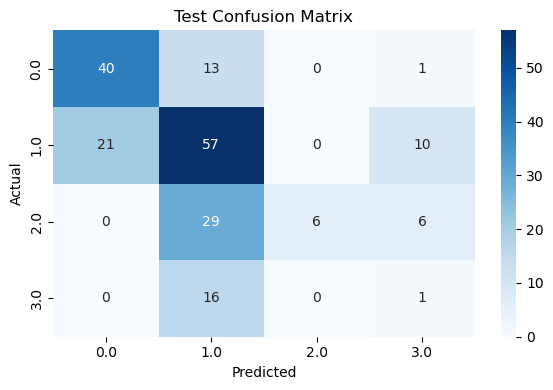


Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.74      0.70        54
         1.0       0.50      0.65      0.56        88
         2.0       1.00      0.15      0.26        41
         3.0       0.06      0.06      0.06        17

    accuracy                           0.52       200
   macro avg       0.55      0.40      0.39       200
weighted avg       0.60      0.52      0.49       200

SHAP exposition …


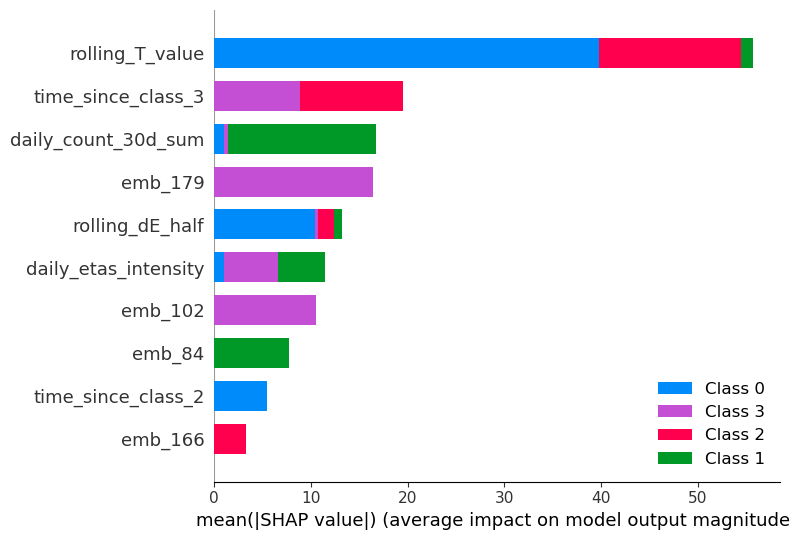

In [1]:
# ----------------------------------------------------------
# 0. Imports
# ----------------------------------------------------------
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
import shap                                      # Explainability

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score,
                             classification_report, roc_curve, auc)

# ------------------ Model Imports ------------------
from xgboost import XGBRegressor, XGBClassifier
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


# ----------------------------------------------------------
# 1. Data utilities
# ----------------------------------------------------------
# ----------------------------------------------------------
# 1. Data utilities  ➜  now merges seismic embeddings
# ----------------------------------------------------------
def load_and_split_data(daily_path: str,
                        seismic_path: str,
                        task: str):
    """
    1.  Read the daily-feature table  (df_daily)  and the seismic-window table
        with embeddings  (df_seismic).
    2.  Expand the `embedding` list into emb_0 … emb_(d–1) columns.
    3.  Merge on  (station_code / station)  and  (date == period_end  w/o tz).
    4.  Temporal train / test split.
    """
    # --------------------  read tables  --------------------
    df_daily   = pd.read_parquet(daily_path)
    df_seismic = pd.read_pickle("./earthquake_prediction/data/features/embeddings_190102.pkl") # CHANGE THIS PATH

    # ------------------  explode embeddings  ---------------
    emb_dim   = len(df_seismic.iloc[0, df_seismic.columns.get_loc("embedding")])
    emb_cols  = [f"emb_{i}" for i in range(emb_dim)]
    df_emb    = pd.DataFrame(df_seismic["embedding"].tolist(), columns=emb_cols)

    df_seismic_exp = pd.concat(
        [df_seismic.drop(columns=["embedding"]), df_emb],
        axis=1
    )

    # ------------------  align time keys  ------------------
    df_seismic_exp["period_end"] = (
        pd.to_datetime(df_seismic_exp["period_end"]).dt.tz_convert(None)
    )
    df_seismic_exp["period_end"] = pd.to_datetime(df_seismic_exp["period_end"].dt.date)
    df_daily["date"] = pd.to_datetime(df_daily["date"])

    # ------------------  merge (inner)  --------------------
    df = pd.merge(
        df_daily,                                          # left
        df_seismic_exp.drop(columns=["period_start", "label"]),
        left_on=["date",        "station_code"],
        right_on=["period_end", "station"],
        how="inner",
    ).drop(columns=["period_end", "station"])


    # ------------------  target & feature split ------------
    if task == "regression":
        target = "max_mag_next_30d"
    else:
        target = "target_class"

    
    df = df.dropna(subset=[target]).copy()
    df["date"] = pd.to_datetime(df["date"])      # make sure

    X  = df.drop(columns=["max_mag_next_30d", "target_class"])
    y  = df[target]
    if task == "classification":
        y = y - 1                     # labels start at 0
        # y = y >= 3



    # ---------------  temporal train / test  ---------------
    X_train = X.loc[X.date <  "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-01"].copy()
    y_train = y.loc[X.date <  "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-01"].copy()

    # keep only labels seen in both splits
    common  = set(y_train.unique()) & set(y_test.unique())
    mask_tr = y_train.isin(common)
    mask_te = y_test.isin(common)

    X_train, y_train = X_train.loc[mask_tr].drop(columns=["date"]), y_train[mask_tr]
    X_test,  y_test  = X_test.loc[mask_te].drop(columns=["date"]),  y_test[mask_te]

    print(f"Data ready. Train rows: {len(X_train)}, Test rows: {len(X_test)}")
    return X_train, X_test, y_train, y_test

#import PCA from sklearn
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import KernelPCA
from sklearn.manifold import Isomap
import umap

def build_preprocessor():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler",  StandardScaler()),
        # ("pca",     PCA(n_components=0.8)),
        # ("isomap",    Isomap(n_components=10, n_neighbors=15))
        # ("umap",    umap.UMAP(n_components=10))
        # ("ica", FastICA(n_components=10, rand\om_state=0))
    ])


# ----------------------------------------------------------
# 2. Model factory  (unchanged)
# ----------------------------------------------------------
def get_model_and_param_grid(model_name: str, task: str, y_train=None):
    # ------------- add / adjust models as needed -------------
    if task == "regression":
        if model_name == "XGBRegressor":
            model = XGBRegressor(
                n_estimators=1_000, learning_rate=0.01, max_depth=3,
                min_child_weight=10, gamma=0.5, subsample=0.7,
                colsample_bytree=0.7, reg_lambda=10, reg_alpha=1,
                random_state=42
            )
            param_grid = {"model__max_depth":[3,5],
                          "model__learning_rate":[0.01,0.05],
                          "model__min_child_weight":[10,20]}
        else:
            model, param_grid = LinearRegression(), {}
    else:  # classification
        if model_name == "LGBMClassifier":
            model = LGBMClassifier(
                num_leaves=10, max_depth=2, min_child_samples=50,
                colsample_bytree=0.7, subsample=0.7,
                learning_rate=0.01, n_estimators=50, boosting_type="rf",
                reg_alpha=0.8, reg_lambda=0.8, cat_smooth=10,
                is_unbalance=True, random_state=42, verbose=-1
            )
            param_grid = {"model__num_leaves":[15,31,50],
                          "model__learning_rate":[0.005,0.01,0.05]}
        else:
            model, param_grid = LogisticRegression(max_iter=1_000), {"model__C":[0.1,1,10]}
    return model, param_grid


# ----------------------------------------------------------
# 3-a. Post-hoc threshold logic
# ----------------------------------------------------------
def predict_with_thresholds(pipe, X, thresholds=None, default_rule="argmax"):
    """
    Force a prediction to class k whenever proba[k] ≥ τ_k.
    """
    if not thresholds:
        return pipe.predict(X)

    proba   = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_
    idx_map = {c:i for i,c in enumerate(classes)}

    preds = np.argmax(proba, axis=1) if default_rule=="argmax" \
            else np.full(len(X), -1)

    for cls, τ in thresholds.items():
        if cls not in idx_map: continue
        preds[proba[:, idx_map[cls]] >= τ] = cls
    return preds


# ----------------------------------------------------------
# 3-b.  Plotting & evaluation  (ROC now handles 2 or >2 classes)
# ----------------------------------------------------------
def plot_roc_auc(pipe, X, y, dataset):
    """
    Draw a single ROC curve for binary problems, or
    One-vs-Rest curves for multi-class.
    """
    if not hasattr(pipe.named_steps["model"], "predict_proba"):
        print("Model lacks predict_proba – skipping ROC curves.")
        return

    y_score = pipe.predict_proba(X)
    classes = pipe.named_steps["model"].classes_

    plt.figure(figsize=(7, 5))
    if len(classes) == 2:
        pos_proba = y_score[:, 1]          # column 1 → positive class
        fpr, tpr, _ = roc_curve(y, pos_proba)
        plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC curve (binary)")
    else:
        y_bin = label_binarize(y, classes=classes)
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, lw=2, label=f"Class {cls} (AUC={auc(fpr,tpr):.3f})")
        plt.title(f"{dataset} ROC – One-vs-Rest")

    plt.plot([0,1],[0,1],"--",color="gray")
    plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
    plt.legend(); plt.grid(alpha=0.3); plt.tight_layout(); plt.show()


def evaluate_regression(pipe, X, y, dataset):
    y_pred = pipe.predict(X)
    print(f"{dataset} → MSE:{mean_squared_error(y,y_pred):.4f} | "
          f"MAE:{mean_absolute_error(y,y_pred):.4f} | "
          f"R²:{r2_score(y,y_pred):.4f}")


def evaluate_classification(pipe, X, y, dataset, thresholds=None):
    y_pred  = predict_with_thresholds(pipe, X, thresholds)
    acc     = accuracy_score(y, y_pred)
    cm      = confusion_matrix(y, y_pred)
    print(f"{dataset} accuracy:{acc:.4f}\nConfusion matrix:\n{cm}")

    # Compute and print average ROC AUC
    if hasattr(pipe.named_steps["model"], "predict_proba"):
        y_score = pipe.predict_proba(X)
        classes = pipe.named_steps["model"].classes_
        y_bin = label_binarize(y, classes=classes)
        aucs = []
        for i in range(len(classes)):
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            aucs.append(auc(fpr, tpr))
        avg_auc = np.mean(aucs)
        print(f"{dataset} average ROC AUC: {avg_auc:.4f}")
    else:
        print(f"{dataset} → model lacks predict_proba; skipping AUC.")

    plot_roc_auc(pipe, X, y, dataset)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.title(f"{dataset} Confusion Matrix")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.tight_layout(); plt.show()

    print("\nClassification Report:")
    print(classification_report(y, y_pred))



def plot_shap_values(pipe, X, model_name):
    tree      = pipe.named_steps["model"]
    X_trans   = pipe.named_steps["preprocessor"].transform(X)
    explainer = shap.TreeExplainer(tree)
    shap_vals = explainer.shap_values(X_trans)

    shap.summary_plot(
        shap_vals,
        X_trans,
        feature_names=list(X.columns),
        plot_type="bar",
        max_display=10,
        show=True
    )

# ----------------------------------------------------------
# 4. Run-level parameters
# ----------------------------------------------------------
task        = "classification"     # "regression" or "classification"
do_tuning   = False
models_to_run = ["LGBMClassifier"] if task=="classification" else ["XGBRegressor"]

# ---- Optional post-hoc probability thresholds --------
apply_thresholds = True
class_thresholds = {2: 0.30, 3: 0.15}       # example for multi-class use-case


# ----------------------------------------------------------
# 5. Pipeline run
# ----------------------------------------------------------
X_train, X_test, y_train, y_test = load_and_split_data(
    daily_path   = "./earthquake_prediction/data/features/earthquake_features.parquet",
    seismic_path = "./earthquake_prediction/data/features/df_seismic.parquet",   # << path to your seismic file
    task = task
)


# drop sparse / list columns
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) \
          + [c for c in X_train.columns if "list" in c]

X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# keep top-10 features
# keep top engineered features + ALL embedding columns
emb_cols  = [c for c in X_train.columns if c.startswith("emb_")]
top_feats = [
    # "time_since_class_4",
    "time_since_class_3",
    "rolling_T_value",
             "daily_count_30d_sum","daily_b_value","rolling_dE_half",
             "daily_etas_intensity","time_since_class_2","daily_count_7d_sum"]

X_train = X_train[top_feats + emb_cols]
X_test  = X_test [top_feats + emb_cols]
# X_train = X_train[emb_cols]
# X_test = X_test[emb_cols]

preprocessor = build_preprocessor()
cv_split     = TimeSeriesSplit(n_splits=3)

for mdl in models_to_run:
    print("\n"+"="*75)
    print(f"Model: {mdl}")

    model, param_grid = get_model_and_param_grid(mdl, task, y_train)
    pipe = Pipeline([("preprocessor", preprocessor), ("model", model)])

    if do_tuning and param_grid:
        search = RandomizedSearchCV(
            pipe, param_distributions=param_grid, cv=cv_split,
            scoring="accuracy" if task=="classification" else "r2",
            n_iter=50, random_state=42, n_jobs=-1, verbose=2
        ).fit(X_train, y_train)
        pipe = search.best_estimator_
        print("Best params:", search.best_params_)
    else:
        pipe.fit(X_train, y_train)

    thresh = class_thresholds if (apply_thresholds and task=="classification") else None

    if task == "regression":
        evaluate_regression(pipe, X_train, y_train, "Train")
        evaluate_regression(pipe, X_test,  y_test,  "Test")
    else:
        evaluate_classification(pipe, X_train, y_train, "Train", thresholds=thresh)
        evaluate_classification(pipe, X_test,  y_test,  "Test",  thresholds=thresh)

    print("SHAP exposition …")
    plot_shap_values(pipe, X_train, mdl)
    print("="*75+"\n")

## GNN exploration

In [19]:
# ==========================================================
# 0. Imports
# ==========================================================
import os, warnings, math, json
import pandas as pd
import numpy as np
from typing import List, Dict, Tuple

warnings.filterwarnings("ignore")

import torch
from torch import nn
from torch.utils.data import DataLoader
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import SAGEConv, global_mean_pool          # GraphSAGE
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score,
                             accuracy_score, confusion_matrix, roc_auc_score)

# ----------------------------------------------------------
# GPU config
# ----------------------------------------------------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", DEVICE)

# ==========================================================
# 1.  Graph-construction utilities
# ==========================================================
def build_radius_graph(lat: np.ndarray,
                       lon: np.ndarray,
                       radius_km: float = 300.0,
                       k_fallback: int = 8) -> torch.Tensor:
    """
    Construct an undirected edge_index (2×E) connecting every station
    to all neighbours within `radius_km` (great-circle distance).
    If a station would have no neighbour, connect its `k_fallback` NNs.
    """
    # --- haversine great-circle distance (vectorised) ------------------
    R = 6371.0                                         # Earth radius [km]
    lat_r = np.radians(lat[:,None])
    lon_r = np.radians(lon[:,None])
    dlat = lat_r.T - lat_r
    dlon = lon_r.T - lon_r
    a = np.sin(dlat/2.0)**2 + np.cos(lat_r)*np.cos(lat_r.T)*(np.sin(dlon/2.0)**2)
    dist = 2.0*R*np.arcsin(np.sqrt(np.clip(a, 0, 1)))  # N×N

    N = len(lat)
    edges: List[Tuple[int,int]] = []

    for i in range(N):
        # neighbours within radius (exclude self)
        nbrs = np.where((dist[i] <= radius_km) & (dist[i]>0))[0].tolist()
        if not nbrs:
            # fallback: k nearest (excluding self)
            nbrs = np.argsort(dist[i])[1:k_fallback+1].tolist()
        edges.extend([(i,j) for j in nbrs])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index

# ==========================================================
# 2. PyG Dataset (one Data object per date-snapshot)
# ==========================================================
class EarthquakeGraphDataset(Dataset):
    """
    Each item is the *graph snapshot* for a single calendar date:
        • x      : [N_nodes,  F]     node-features for that day
        • y      : [N_nodes]         target per station
        • edge_index  constant for all snapshots (built once)
    """
    def __init__(self,
                 df_feat:  pd.DataFrame,
                 df_meta:  pd.DataFrame,
                 feature_cols: List[str],
                 target_col: str,
                 edge_index: torch.Tensor,
                 dates: List[pd.Timestamp]):
        super().__init__()
        self.df    = df_feat
        self.meta  = df_meta
        self.feats = feature_cols
        self.tgt   = target_col
        self.edge_index = edge_index
        self.dates = dates
        # Pre-map (station_code → 0 … N-1)
        self.code2idx = {c:i for i,c in enumerate(self.meta.station_code.values)}
        self.N = len(self.meta)

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        day = self.dates[idx]
        df_d = self.df[self.df.date == day]                      # rows of that date
        # Ensure one row per station; fill missing stations with NaNs
        x = np.full((self.N, len(self.feats)), np.nan, dtype=np.float32)
        y = np.full(self.N,          np.nan, dtype=np.float32)

        for _, row in df_d.iterrows():
            j = self.code2idx[row.station_code]
            x[j] = row[self.feats].astype(np.float32).values
            y[j] = row[self.tgt].astype(np.float32)

        # simple median imputing for missing nodes
        nan_mask = np.isnan(x)
        if nan_mask.any():
            col_median = np.nanmedian(x, axis=0)
            x[nan_mask] = np.take(col_median, np.where(nan_mask)[1])
        y = np.nan_to_num(y, nan=np.nanmean(y))                  # crude

        data = Data(x=torch.from_numpy(x),
                    edge_index=self.edge_index,
                    y=torch.from_numpy(y),
                    date=str(day.date()))
        return data

# ==========================================================
# 3.  Graph Neural Network model
# ==========================================================
class StationGNN(nn.Module):
    """
    Simple 3-layer GraphSAGE followed by per-node MLP head.
    Works for *regression* (default) or *classification* (set `n_classes > 1`).
    """
    def __init__(self,
                 in_dim: int,
                 hidden_dim: int = 128,
                 n_layers: int  = 3,
                 n_classes: int = 1):
        super().__init__()
        self.convs = nn.ModuleList()
        self.convs.append(SAGEConv(in_dim, hidden_dim))
        for _ in range(n_layers-2):
            self.convs.append(SAGEConv(hidden_dim, hidden_dim))
        self.convs.append(SAGEConv(hidden_dim, hidden_dim))

        out_dim = n_classes if n_classes > 1 else 1
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, out_dim)
        )
        self.n_classes = n_classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        for conv in self.convs:
            x = conv(x, edge_index)
            x = nn.functional.relu(x)
        return self.head(x)                       # [N_nodes, out]

# ==========================================================
# 4.  Data  –  load & split
# ==========================================================
def load_data_files(feat_path: str,
                    meta_path: str,
                    task: str):
    df = pd.read_parquet(feat_path).drop(columns=["magnitudes_list"])
    df["date"] = pd.to_datetime(df["date"])
    df_meta = pd.read_parquet(meta_path)[["station_code","latitude","longitude"]].drop_duplicates()

    target = "max_mag_next_30d" if task=="regression" else "target_class"

    df = df.dropna(subset=[target])
    if task == "classification":
        df[target] = df[target] - 1

    return df, df_meta, target

def temporal_split_dates(df: pd.DataFrame,
                         split_date_train: str = "2024-01-01",
                         split_date_test : str = "2024-01-30"):
    train_dates = sorted(df.loc[df.date <  split_date_train, "date"].unique())
    test_dates  = sorted(df.loc[df.date >= split_date_test, "date"].unique())
    return train_dates, test_dates

# ==========================================================
# 5.  Train / evaluate helpers
# ==========================================================
def train_one_epoch(model, loader, optim, loss_fn):
    model.train()
    total_loss = 0.0
    for data in loader:
        data = data.to(DEVICE)
        optim.zero_grad()
        out = model(data).squeeze()
        loss = loss_fn(out, data.y)
        loss.backward()
        optim.step()
        total_loss += loss.item()*len(data.y)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, task:str):
    model.eval()
    preds, trues = [], []
    for data in loader:
        data = data.to(DEVICE)
        out = model(data).squeeze()
        preds.append(out.cpu().numpy())
        trues.append(data.y.cpu().numpy())
    y_pred = np.concatenate(preds)
    y_true = np.concatenate(trues)

    if task=="regression":
        print(f" MSE:{mean_squared_error(y_true,y_pred):.4f} "
              f"| MAE:{mean_absolute_error(y_true,y_pred):.4f} "
              f"| R²:{r2_score(y_true,y_pred):.4f}")
    else:
        y_pred_cls = (y_pred if model.n_classes>1 else (y_pred>0.5)).astype(int)
        print(f" accuracy:{accuracy_score(y_true,y_pred_cls):.4f}")
        print(" Confusion matrix:\n", confusion_matrix(y_true,y_pred_cls))

# ==========================================================
# 6.  Main run
# ==========================================================
if __name__ == "__main__":
    # ---------- parameters ---------------------------------
    TASK          = "classification"             # "regression"
    FEAT_PATH     = "./earthquake_prediction/data/features/earthquake_features.parquet"
    META_PATH     = "./earthquake_prediction/data/raw/earthquake_data.parquet"
    TOP_FEATS     = [
        "time_since_class_4","time_since_class_3","rolling_T_value",
        "daily_count_30d_sum","daily_b_value","rolling_dE_half",
        "daily_etas_intensity","time_since_class_2","daily_count_7d_sum"
    ]
    BATCH_SIZE    = 16            # #graphs per batch (= #dates per batch)
    EPOCHS        = 40
    LR            = 1e-3
    HIDDEN_DIM    = 128
    RADIUS_KM     = 300.0

    # ---------- load & prepare ------------------------------
    df, df_meta, target_col = load_data_files(FEAT_PATH, META_PATH, TASK)
    df = df[ df.columns.intersection(["station_code","date",target_col]+TOP_FEATS) ]

    # Build global (static) edge_index
    edge_index = build_radius_graph(df_meta.latitude.values,
                                    df_meta.longitude.values,
                                    radius_km=RADIUS_KM)

    # Train / test date split
    train_dates, test_dates = temporal_split_dates(df)

    # PyG datasets
    ds_train = EarthquakeGraphDataset(df, df_meta, TOP_FEATS, target_col,
                                      edge_index, train_dates)
    ds_test  = EarthquakeGraphDataset(df, df_meta, TOP_FEATS, target_col,
                                      edge_index, test_dates)

    dl_train = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)
    dl_test  = DataLoader(ds_test,  batch_size=BATCH_SIZE, shuffle=False)

    # ---------- model / loss --------------------------------
    n_classes = df[target_col].nunique() if TASK=="classification" else 1
    model = StationGNN(in_dim=len(TOP_FEATS),
                       hidden_dim=HIDDEN_DIM,
                       n_layers=3,
                       n_classes=n_classes).to(DEVICE)

    loss_fn = (nn.CrossEntropyLoss()
               if TASK=="classification" and n_classes>1
               else nn.BCEWithLogitsLoss()
               if TASK=="classification" else nn.MSELoss())

    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    # ---------- training loop ------------------------------
    for epoch in range(1, EPOCHS+1):
        tr_loss = train_one_epoch(model, dl_train, optimizer, loss_fn)
        print(f"Epoch {epoch:>3} | train-loss {tr_loss:.4f}", end="")
        if epoch % 5 == 0 or epoch==EPOCHS:
            print(" | test:", end="")
            evaluate(model, dl_test, TASK)
        else:
            print()

    # ---------- final evaluation ---------------------------
    print("\nFinal train metrics:")
    evaluate(model, dl_train, TASK)
    print("Final test metrics:")
    evaluate(model, dl_test, TASK)

Running on: cpu


MemoryError: Unable to allocate 50.0 TiB for an array with shape (2620720, 2620720) and data type float64

## (Old) Focal Loss code

Loading and splitting data...
Data loading complete.
Building preprocessor pipeline...
Number of classes: 2
Accuracy: 0.6332312404287902
Confusion Matrix:
[[754 365]
 [114  73]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.67      0.76      1119
        True       0.17      0.39      0.23       187

    accuracy                           0.63      1306
   macro avg       0.52      0.53      0.50      1306
weighted avg       0.77      0.63      0.68      1306



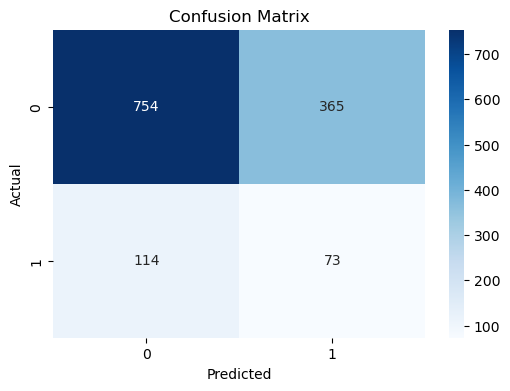

<Figure size 640x480 with 0 Axes>

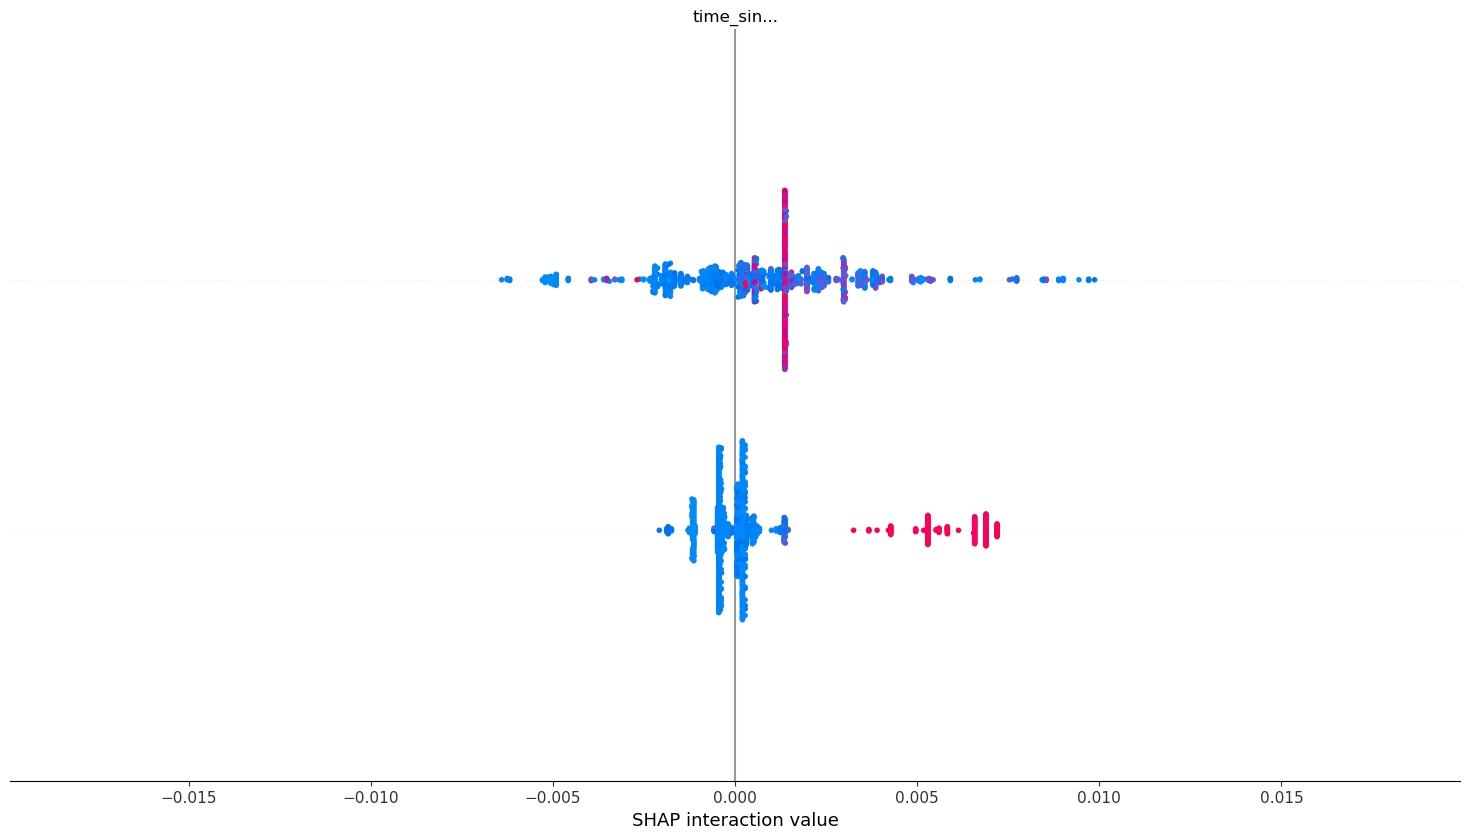

In [40]:
import pandas as pd
import numpy as np
import warnings

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")

# ------------------ Custom Multiclass Focal Loss Functions ------------------
from scipy.misc import derivative

def focal_loss_lgb_multiclass(y_pred, dtrain, alpha, gamma):
    """
    Custom multiclass focal loss objective for LightGBM.
    Uses numerical finite differences to approximate gradients and Hessians.
    
    Parameters:
      y_pred: flat array of raw predictions (logits) of shape (n_samples * num_class,)
      dtrain: LightGBM Dataset, from which true labels are extracted via dtrain.get_label()
      alpha: weighting factor (e.g. 0.25)
      gamma: focusing parameter (e.g. 1)
      
    Returns:
      grad: flattened gradients (n_samples * num_class,)
      hess: flattened Hessians (n_samples * num_class,)
    """
    # Determine number of classes from the true labels.
    y_true = dtrain.get_label().astype(int)
    num_class = int(np.max(y_true)) + 1
    n_samples = dtrain.num_data()
    
    # Reshape predictions to (n_samples, num_class)
    y_pred = y_pred.reshape(n_samples, num_class)
    
    # Initialize gradient and hessian arrays
    grad = np.zeros_like(y_pred)
    hess = np.zeros_like(y_pred)
    eps = 1e-6  # finite difference step
    
    # For each sample, approximate partial derivatives for each class score
    for i in range(n_samples):
        for k in range(num_class):
            # Define a scalar function f that perturbs the k-th logit only
            def f(z):
                z_vec = y_pred[i].copy()
                z_vec[k] = z
                # Compute softmax probabilities
                exp_z = np.exp(z_vec - np.max(z_vec))
                p = exp_z / np.sum(exp_z)
                # Focal loss for this sample: only the true class term contributes.
                loss = -alpha * ((1 - p[y_true[i]])**gamma) * np.log(p[y_true[i]] + 1e-12)
                return loss
            z0 = y_pred[i, k]
            # Central difference for first derivative
            grad[i, k] = (f(z0 + eps) - f(z0 - eps)) / (2 * eps)
            # Second derivative approximation
            hess[i, k] = (f(z0 + eps) - 2 * f(z0) + f(z0 - eps)) / (eps ** 2)
    
    return grad.reshape(-1), hess.reshape(-1)

def focal_loss_lgb_multiclass_eval(y_pred, dtrain, alpha, gamma):
    """
    Custom evaluation metric for multiclass focal loss.
    
    Returns:
      A tuple (metric_name, value, is_higher_better)
    """
    y_true = dtrain.get_label().astype(int)
    num_class = int(np.max(y_true)) + 1
    n_samples = dtrain.num_data()
    
    y_pred = y_pred.reshape(n_samples, num_class)
    loss_sum = 0.0
    for i in range(n_samples):
        exp_z = np.exp(y_pred[i] - np.max(y_pred[i]))
        p = exp_z / np.sum(exp_z)
        loss_sum += -alpha * ((1 - p[y_true[i]])**gamma) * np.log(p[y_true[i]] + 1e-12)
    return 'focal_loss', loss_sum / n_samples, False

# Lambdas wrapping our functions with alpha=0.25 and gamma=1.
focal_loss_multiclass = lambda y_pred, dtrain: focal_loss_lgb_multiclass(y_pred, dtrain, 1.0, 0.1)
focal_loss_multiclass_eval = lambda y_pred, dtrain: focal_loss_lgb_multiclass_eval(y_pred, dtrain, 1.0, 0.1)

# ------------------ Other Imports ------------------
import lightgbm as lgb
import shap
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# =============================================================================
# Data Loading & Preprocessing Functions
# =============================================================================

def load_and_split_data(path: str, task: str):
    """
    Load the dataset, clean it, and perform a temporal train-test split.
    """
    print("Loading and splitting data...")
    df = pd.read_parquet(path)
    df = df.drop(columns=["magnitudes_list"])
    
    if task == "regression":
        df = df.dropna(subset=["max_mag_next_30d"])
    else:
        df = df.dropna(subset=["target_class"])
    
    df["date"] = pd.to_datetime(df["date"])
    df.drop(columns=["daily_max_30d_mean"], inplace=True)
    
    target_col = "max_mag_next_30d" if task=="regression" else "target_class"
    X = df.drop(columns=["max_mag_next_30d", "target_class"])
    y = df[target_col]
    
    if task == "classification":
        y = y - 1  # shift labels so they start at 0

    # Temporal split: Train before 2024-01-01, Test from 2024-01-30 onward
    X_train = X.loc[X.date < "2024-01-01"].copy()
    X_test  = X.loc[X.date >= "2024-01-30"].copy()
    y_train = y.loc[X.date < "2024-01-01"].copy()
    y_test  = y.loc[X.date >= "2024-01-30"].copy()

    # Find classes present in both y_train and y_test
    train_classes = set(y_train.unique())
    test_classes = set(y_test.unique())
    common_classes = train_classes & test_classes  # intersection

    # Filter y
    y_train = y_train[y_train.isin(common_classes)].copy()
    y_test = y_test[y_test.isin(common_classes)].copy()

    # Filter X based on filtered y
    X_train = X_train.loc[y_train.index].copy()
    X_test = X_test.loc[y_test.index].copy()
    
    X_train = X_train.drop(columns=["date"])
    X_test  = X_test.drop(columns=["date"])
    
    print("Data loading complete.")
    return X_train, X_test, y_train, y_test

def build_preprocessor():
    """
    Build a preprocessing pipeline with median imputation and standard scaling.
    """
    print("Building preprocessor pipeline...")
    return Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

# =============================================================================
# Main Script
# =============================================================================

# Set task to "classification" (multiclass)
task = "classification"

# Load and split data (adjust the path as needed)
X_train, X_test, y_train, y_test = load_and_split_data("data/features/earthquake_features.parquet", task)

# Drop columns with ≥50% missing values and any columns containing "list"
drop_cols = list(X_train.columns[X_train.isna().mean() >= 0.5]) + [col for col in X_train.columns if "list" in col]
X_train.drop(columns=drop_cols, inplace=True)
X_test.drop(columns=drop_cols, inplace=True)

# Select top 10 features
top_10_features = [
    "time_since_class_4",
    "time_since_class_3",
    "rolling_T_value",
    "daily_count_30d_sum",
    "daily_b_value",
    "rolling_dE_half",
    "daily_etas_intensity",
    "time_since_class_2",
    # "daily_min",
    "daily_count_7d_sum"
]
X_train = X_train[top_10_features]
X_test = X_test[top_10_features]

# Build and apply preprocessor
preprocessor = build_preprocessor()
X_train_trans = preprocessor.fit_transform(X_train)
X_test_trans  = preprocessor.transform(X_test)

# Create native LightGBM Datasets
lgb_train = lgb.Dataset(X_train_trans, label=y_train, free_raw_data=True)
lgb_eval  = lgb.Dataset(X_test_trans, label=y_test)

# Determine number of classes from training labels
num_class = int(np.max(y_train)) + 1
print("Number of classes:", num_class)

# Set training parameters (using your provided LGBMClassifier settings)
params = {
    # 'boosting_type': 'rf',         # Using RF boosting as in your classifier
    'num_leaves': 10,              # Lower value reduces model complexity
    'max_depth': 2,                # Limits tree depth
    'min_data_in_leaf': 50,        # Minimum number of data points per leaf
    'reg_alpha': 0.8,              # L1 regularization
    'reg_lambda': 0.8,             # L2 regularization
    'colsample_bytree': 0.7,       # Fraction of features used per tree
    'subsample': 0.7,              # Fraction of samples used per boosting round
    'subsample_freq': 1,           # Frequency of subsampling
    'learning_rate': 0.01,         # Lower learning rate to reduce overfitting
    'min_gain_to_split': 0.01,     # Minimum loss reduction required to split
    'max_bin': 255,                # Maximum bin value for discretizing features
    'cat_smooth': 10,              # Smoothing for categorical features
    'is_unbalance': True,          # Handle imbalanced datasets
    'seed': 42,                    # For reproducibility
    'verbose': -1,                 # Suppress logs
    'num_class': num_class,        # Number of classes for multiclass classification
    'objective': focal_loss_multiclass  # Custom focal loss objective
    # "objective": 'multiclass'
}
num_boost_round = 50  # Set n_estimators equivalent

# Train model using lgb.train with custom multiclass focal loss eval metric
model = lgb.train(params,
                  lgb_train,
                  valid_sets=[lgb_eval],
                  num_boost_round=num_boost_round,
                #   feval=focal_loss_multiclass_eval
                  )

# Make predictions on the test set
# For multiclass, model.predict returns a flat array; reshape and take argmax.
y_pred_prob = model.predict(X_test_trans)
y_pred = np.argmax(y_pred_prob.reshape(-1, num_class), axis=1)

# Evaluate predictions
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ------------------- ROC-AUC Plot for Multiclass -------------------

# Binarize the true labels for ROC calculation
# y_test_bin = label_binarize(y_test, classes=np.arange(num_class))
# y_score = y_pred_prob  # shape: (n_samples, n_classes)

# # Compute ROC curve and ROC area for each class
# fpr = dict()
# tpr = dict()
# roc_auc = dict()
# for i in range(num_class):
#     fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
#     roc_auc[i] = auc(fpr[i], tpr[i])

# # Compute macro-average ROC AUC
# all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_class)]))
# mean_tpr = np.zeros_like(all_fpr)
# for i in range(num_class):
#     mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
# mean_tpr /= num_class
# fpr["macro"] = all_fpr
# tpr["macro"] = mean_tpr
# roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# # Plot all ROC curves
# plt.figure(figsize=(8, 6))
# colors = sns.color_palette("tab10", num_class)
# for i, color in zip(range(num_class), colors):
#     plt.plot(fpr[i], tpr[i], color=color, lw=2,
#              label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

# plt.plot(fpr["macro"], tpr["macro"], color='black', linestyle='--',
#          label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})', lw=2)

# plt.plot([0, 1], [0, 1], 'k--', lw=1)
# plt.xlim([-0.01, 1.01])
# plt.ylim([-0.01, 1.01])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Multiclass ROC Curve')
# plt.legend(loc="lower right")
# plt.grid(True)
# plt.show()


# Plot confusion matrix heatmap
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Compute and plot SHAP values for model explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_trans)
shap.summary_plot(shap_values, X_test_trans, feature_names=top_10_features, plot_type='bar', max_display=10)

